In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
input_dim=7
cond_dim=3
latent_dim=5
n_hidden=5
hidden_size=16
batch_size=10000

We have derived that

$\tilde{A_i} = (G^T\Sigma_i^{-1}G)^{-1}G^T\Sigma_i^{-1}\vec{R}_{i,obs}.$

$
\rm
Cov(\tilde{A_i},\tilde{A_i}) = B\ Cov(R_{i,obs},R_{i,obs})\ B^T = B\ \Sigma_i\ B^T,
$
where $B = (G^T\Sigma_i^{-1}G)^{-1}G^T\Sigma_i^{-1}$.

$
Cov(\tilde{A_i},\tilde{A_i}) = (G^T\Sigma_i^{-1}G)^{-1}G^T\Sigma_i^{-1}\Sigma_i\Sigma_i^{-1}G(G^T\Sigma_i^{-1}G)^{-1}=(G^T\Sigma_i^{-1}G)^{-1}.
$

=>We should provide different cov-matrices to different stars
$
Cov(\tilde{A_i},\tilde{A_i})^{-1} = (G^T\Sigma_i^{-1}G)
$


In [2]:
A = np.load('A_real.npy').T

A_mean = np.mean(A,axis=0)

A_std = np.std(A,axis=0)/5.# std is larger due to extreme values

A = (A-A_mean)/A_std
print(A_std)


[2.4047331  0.83711309 1.96299641 1.15170003 0.94973234 0.94772497
 0.57143773]


If some stars have more than 6 bands missing, this will still set constraints on G, but is not helpful to show the pattern of A, and will ruin the std.

We should have removed those 'bad A_parameters'.

In [3]:
safe = np.where(np.abs(A[:,0])<1.0)[0]
for i in range(7):
    x = A[:,i]
    y = np.where(np.abs(A[:,i])<1.0)[0]
    safe = np.union1d(safe,y)
print(safe)


[      0       1       2 ... 2888358 2888359 2888360]


In [4]:
len(safe)/len(x)

0.9646626581649593

This is a naive bar (30.01.2022 version), we throw away all of the large A, which only take up less than 4%

In [5]:
import h5py as hp
f = hp.File('/home/seanzhang/0_mpia/code/apogee_lamost_galah_data.h5','r')
d = f['io_data']
param = d['atm_param_p']
f.close()

In [6]:
Cov_A_1 = np.load('Cov_A_1_normal.npy')/25.# normalized by mean value of A, and devided by 25 since A is timed 5

In [7]:
A = A[safe]
Cov_A_1 = Cov_A_1[safe]
param = param[safe]

In [8]:
def sum_chi2(y_true,y_pred):
    #loss function, summation of chi2 per DOF
    return tf.reduce_sum(y_pred)/batch_size/input_dim

In [9]:
class ConditionalAutoencoder(keras.Model):
    '''
    Basically the same structure in your toy model
    
    '''
    def __init__(self, input_dim, cond_dim, latent_dim,
               n_hidden, hidden_size, l2=1e-4):
            super(ConditionalAutoencoder, self).__init__()

            hidden_dim = [hidden_size for i in range(n_hidden)]
            print('hidden dimensions:', hidden_dim)

            x = keras.layers.Input(input_dim, name='x')
            z = keras.layers.Input(cond_dim, name='z')

            layer = keras.layers.Concatenate(
                axis=1, name='xz')([x, z])
            for k,d in enumerate(hidden_dim):
                layer = keras.layers.Dense(
                d, activation='tanh',
                kernel_regularizer=keras.regularizers.l2(l2),
                name=f'hidden_{k+1}'
                )(layer)
            layer = keras.layers.Dense(
                latent_dim,
                activation='tanh',
                name='y'
                )(layer)         
            self.encoder = tf.keras.Model(
                inputs=[x,z],
                outputs=layer,
                name='encoder'
                )

            y = keras.layers.Input(latent_dim, name='y')
            z = keras.layers.Input(cond_dim, name='z')
            
            layer = keras.layers.Concatenate(
                axis=1, name='yz'
                )([y, z])
            for k,d in enumerate(hidden_dim):
                layer = keras.layers.Dense(
                    d, activation='tanh',
                    kernel_regularizer=keras.regularizers.l2(l2),#version problem? L2(with Cap L) will cause errors.
                    name=f'hidden_{k+1}'
                    )(layer)
            layer = keras.layers.Dense(
                input_dim,
                name='x'
                )(layer)            
            
            self.decoder = tf.keras.Model(
            inputs=[y,z],
            outputs=layer,
            name='decoder'
            )
            
    def call(self, xzc):
            x,z,c_1 = xzc
            y = self.encode(x, z)
            xp = self.decode(y, z)
            dx = x-xp
            chi2 = tf.einsum('ij,ijk,ik->i',dx,c_1,dx)
            return chi2# output chi2 to generate loss function
        
    def encode(self, x, z):
            return self.encoder([x, z])
    def decode(self, y, z):
            return self.decoder([y, z])




In [10]:
model = ConditionalAutoencoder(input_dim=7, cond_dim=3, latent_dim=4,
               n_hidden=4, hidden_size=16, l2=1e-4)
model.build([(None,input_dim),(None,cond_dim),(None,input_dim,input_dim)])
model.summary()

hidden dimensions: [16, 16, 16, 16]
Model: "conditional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, 4)                 1060      
_________________________________________________________________
decoder (Functional)         (None, 7)                 1063      
Total params: 2,123
Trainable params: 2,123
Non-trainable params: 0
_________________________________________________________________


In [11]:
opt = keras.optimizers.Adam(learning_rate=0.01)

In [12]:
model.compile(optimizer=opt, loss=sum_chi2)

In [13]:
A.shape

(2786294, 7)

In [14]:
param.shape

(2786294, 3)

In [15]:
Cov_A_1.shape

(2786294, 7, 7)

In [16]:
x_encoded_history = [model.encode(A[-1024:], param[-1024:]).numpy()]

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=32, verbose=1,
        mode='min', min_delta=1e-4, cooldown=0, min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-5, patience=64, verbose=1,
        mode='min', baseline=None, restore_best_weights=False
    ),
    keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: x_encoded_history.append(
            model.encode(A[-1024:], param[-1024:]).numpy()
        )
    )
]

fit_history = model.fit(
    (A,param,Cov_A_1), np.zeros((A.shape[0],1)),
    batch_size=batch_size,
    epochs=1024,
    validation_split=1/4,
    callbacks=callbacks
)

Epoch 1/1024
209/209 [==============================] - 1s 5ms/step - loss: 17.2723 - val_loss: 2.0605
Epoch 2/1024
209/209 [==============================] - 1s 3ms/step - loss: 2.2735 - val_loss: 1.6608
Epoch 3/1024
209/209 [==============================] - 1s 3ms/step - loss: 2.0628 - val_loss: 1.4466
Epoch 4/1024
209/209 [==============================] - 1s 3ms/step - loss: 1.7189 - val_loss: 1.3632
Epoch 5/1024
209/209 [==============================] - 1s 3ms/step - loss: 1.6690 - val_loss: 1.3053
Epoch 6/1024
209/209 [==============================] - 1s 3ms/step - loss: 1.5534 - val_loss: 1.3356
Epoch 7/1024
209/209 [==============================] - 1s 3ms/step - loss: 1.5043 - val_loss: 1.2747
Epoch 8/1024
209/209 [==============================] - 1s 3ms/step - loss: 1.6010 - val_loss: 1.2392
Epoch 9/1024
209/209 [==============================] - 1s 3ms/step - loss: 1.4657 - val_loss: 1.2185
Epoch 10/1024
209/209 [==============================] - 1s 3ms/step - loss: 1.41

209/209 [==============================] - 1s 3ms/step - loss: 0.8965 - val_loss: 1.0931
Epoch 81/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.8951 - val_loss: 0.8307
Epoch 82/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.9097 - val_loss: 0.8330
Epoch 83/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.9073 - val_loss: 0.9447
Epoch 84/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.8991 - val_loss: 0.8425
Epoch 85/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.8831 - val_loss: 0.8205
Epoch 86/1024
209/209 [==============================] - 1s 3ms/step - loss: 1.0026 - val_loss: 0.8467
Epoch 87/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.9699 - val_loss: 0.9388
Epoch 88/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.8847 - val_loss: 0.8527
Epoch 89/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.9210 - v

209/209 [==============================] - 1s 3ms/step - loss: 0.8026 - val_loss: 0.7740
Epoch 159/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.8307 - val_loss: 0.7845
Epoch 160/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7897 - val_loss: 0.7809
Epoch 161/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.8101 - val_loss: 0.8252
Epoch 162/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.8100 - val_loss: 0.7846
Epoch 163/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7938 - val_loss: 0.7657
Epoch 164/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.8141 - val_loss: 0.7813
Epoch 165/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7972 - val_loss: 0.7900
Epoch 166/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7944 - val_loss: 0.7671
Epoch 167/1024
209/209 [==============================] - 1s 3ms/step - loss: 0

Epoch 237/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7795 - val_loss: 0.7547
Epoch 238/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7816 - val_loss: 0.7546
Epoch 239/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7810 - val_loss: 0.7600
Epoch 240/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7545 - val_loss: 0.8567
Epoch 241/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7808 - val_loss: 0.7621
Epoch 242/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7969 - val_loss: 0.7607
Epoch 243/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7861 - val_loss: 0.7546
Epoch 244/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7999 - val_loss: 0.7907
Epoch 245/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7928 - val_loss: 0.7570
Epoch 246/1024
209/209 [==============================] - 1s 3ms

Epoch 316/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6816 - val_loss: 0.7451
Epoch 317/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7416 - val_loss: 0.7008
Epoch 318/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6600 - val_loss: 0.6985
Epoch 319/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6939 - val_loss: 0.7100
Epoch 320/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7179 - val_loss: 0.6809
Epoch 321/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7167 - val_loss: 0.7396
Epoch 322/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7095 - val_loss: 0.6957
Epoch 323/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.7140 - val_loss: 0.7467
Epoch 324/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6880 - val_loss: 0.6926
Epoch 325/1024
209/209 [==============================] - 1s 3ms

Epoch 394/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6050 - val_loss: 0.6052
Epoch 395/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6240 - val_loss: 0.6120
Epoch 396/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6211 - val_loss: 0.6237
Epoch 397/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6423 - val_loss: 0.6287
Epoch 398/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6066 - val_loss: 0.6112
Epoch 399/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6205 - val_loss: 0.6029
Epoch 400/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5911 - val_loss: 0.6032
Epoch 401/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6094 - val_loss: 0.6133
Epoch 402/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6391 - val_loss: 0.6146
Epoch 403/1024
209/209 [==============================] - 1s 3ms

Epoch 472/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6369 - val_loss: 0.6044
Epoch 473/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5931 - val_loss: 0.5980
Epoch 474/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5920 - val_loss: 0.5966
Epoch 475/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6063 - val_loss: 0.5915
Epoch 476/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5878 - val_loss: 0.5910
Epoch 477/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5975 - val_loss: 0.5960
Epoch 478/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5600 - val_loss: 0.5927
Epoch 479/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5956 - val_loss: 0.5921
Epoch 480/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5803 - val_loss: 0.5911
Epoch 481/1024
209/209 [==============================] - 1s 3ms

Epoch 550/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5973 - val_loss: 0.5835
Epoch 551/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5772 - val_loss: 0.5855
Epoch 552/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6073 - val_loss: 0.5847
Epoch 553/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5940 - val_loss: 0.5832
Epoch 554/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5954 - val_loss: 0.5822
Epoch 555/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5598 - val_loss: 0.5842
Epoch 556/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5856 - val_loss: 0.5815
Epoch 557/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5797 - val_loss: 0.5854
Epoch 558/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5614 - val_loss: 0.5826
Epoch 559/1024
209/209 [==============================] - 1s 3ms

Epoch 629/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5828 - val_loss: 0.5800
Epoch 630/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5791 - val_loss: 0.5825
Epoch 631/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5759 - val_loss: 0.5784
Epoch 632/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5614 - val_loss: 0.5795
Epoch 633/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6042 - val_loss: 0.5790
Epoch 634/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5761 - val_loss: 0.5816
Epoch 635/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5813 - val_loss: 0.5799
Epoch 636/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5679 - val_loss: 0.5786
Epoch 637/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5617 - val_loss: 0.5792
Epoch 638/1024
209/209 [==============================] - 1s 3ms

Epoch 707/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5909 - val_loss: 0.5742
Epoch 708/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5606 - val_loss: 0.5758
Epoch 709/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5628 - val_loss: 0.5744
Epoch 710/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5543 - val_loss: 0.5753
Epoch 711/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5750 - val_loss: 0.5736
Epoch 712/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5870 - val_loss: 0.5744
Epoch 713/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5605 - val_loss: 0.5740
Epoch 714/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5642 - val_loss: 0.5751
Epoch 715/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5726 - val_loss: 0.5743
Epoch 716/1024
209/209 [==============================] - 1s 3ms

Epoch 785/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5636 - val_loss: 0.5698
Epoch 786/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5631 - val_loss: 0.5709
Epoch 787/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5456 - val_loss: 0.5699
Epoch 788/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5567 - val_loss: 0.5707
Epoch 789/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5610 - val_loss: 0.5722
Epoch 790/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5630 - val_loss: 0.5697
Epoch 791/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5489 - val_loss: 0.5697
Epoch 792/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5548 - val_loss: 0.5701
Epoch 793/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5575 - val_loss: 0.5698
Epoch 794/1024
209/209 [==============================] - 1s 3ms

Epoch 864/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5821 - val_loss: 0.5689
Epoch 865/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5386 - val_loss: 0.5682
Epoch 866/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5637 - val_loss: 0.5693
Epoch 867/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5247 - val_loss: 0.5679
Epoch 868/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5735 - val_loss: 0.5691
Epoch 869/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5567 - val_loss: 0.5684
Epoch 870/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5717 - val_loss: 0.5680
Epoch 871/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5522 - val_loss: 0.5688
Epoch 872/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5595 - val_loss: 0.5685
Epoch 873/1024
209/209 [==============================] - 1s 3ms

Epoch 943/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.6034 - val_loss: 0.5667
Epoch 944/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5474 - val_loss: 0.5675
Epoch 945/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5601 - val_loss: 0.5676
Epoch 946/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5606 - val_loss: 0.5667
Epoch 947/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5725 - val_loss: 0.5669
Epoch 948/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5565 - val_loss: 0.5673
Epoch 949/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5661 - val_loss: 0.5676
Epoch 950/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5345 - val_loss: 0.5677
Epoch 951/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5558 - val_loss: 0.5681
Epoch 952/1024
209/209 [==============================] - 1s 3ms

209/209 [==============================] - 1s 3ms/step - loss: 0.5591 - val_loss: 0.5673
Epoch 1022/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5737 - val_loss: 0.5657
Epoch 1023/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5693 - val_loss: 0.5672
Epoch 1024/1024
209/209 [==============================] - 1s 3ms/step - loss: 0.5686 - val_loss: 0.5660


In [17]:
z = model.encoder((A,param))
xp = model.decoder((z,param))

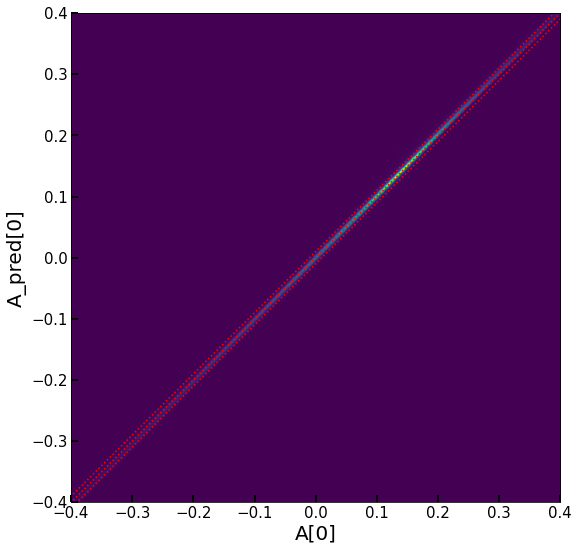

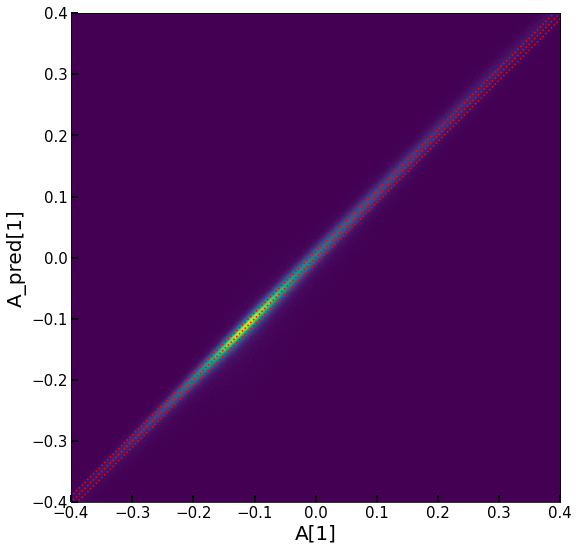

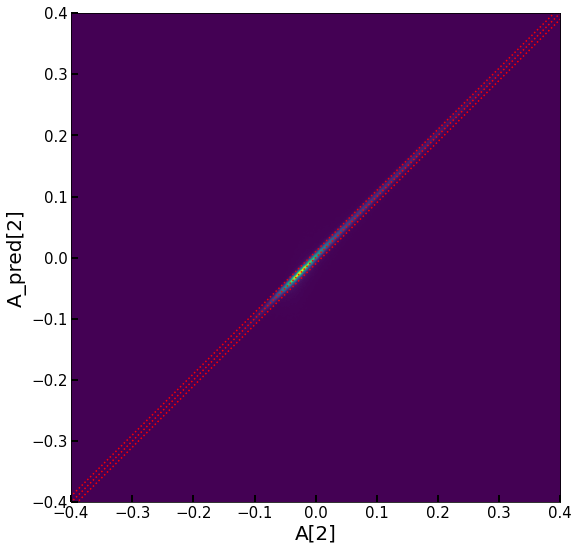

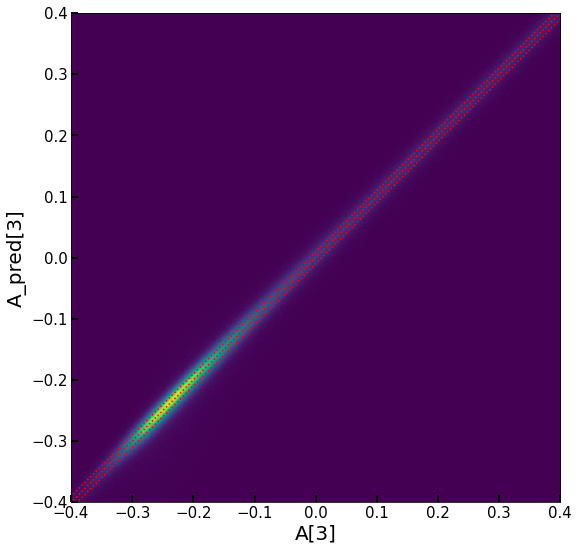

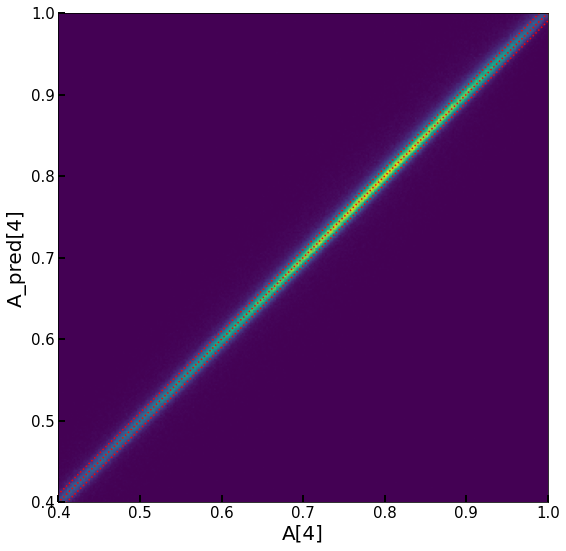

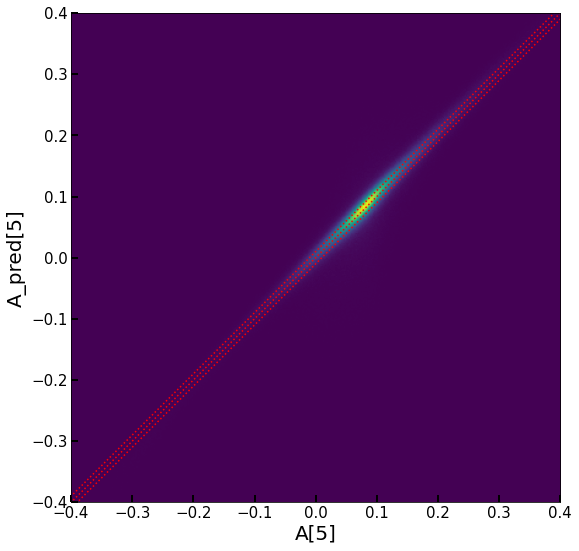

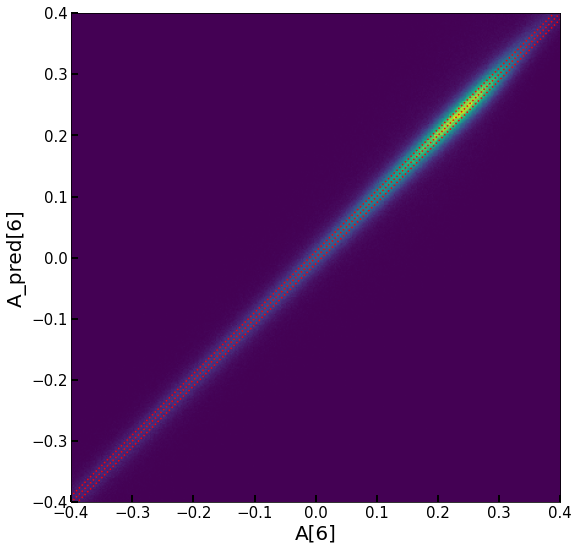

In [18]:
for i in range(7):
    plt.figure(figsize=(9,9))
    x = A[:,i]
    y = xp[:,i]
    range_a = 10.
    range_show = 0.4
    nbins= 10000

    xbins=np.linspace(-range_a,range_a,nbins)
    
    hist2d,xbins,ybins = np.histogram2d(x,y,weights=Cov_A_1[:,i,i],bins=xbins)
    plt.imshow(hist2d[::-1],extent=(-range_a,range_a,-range_a,range_a))
    
    
    

    plt.tick_params(axis='both',labelsize=15, direction = 'in',width=2,length=7,which='major')
    plt.plot(np.linspace(-range_a,range_a,nbins),np.linspace(-range_a,range_a,nbins),':',color='r')
    plt.plot(np.linspace(-range_a,range_a,nbins),np.linspace(-range_a,range_a,nbins)+0.01,':',color='r')
    plt.plot(np.linspace(-range_a,range_a,nbins),np.linspace(-range_a,range_a,nbins)-0.01,':',color='r')
    plt.xlabel('A[%i]'%i,size=20)
    plt.ylabel('A_pred[%i]'%i,size=20)
    

    if(i==4):
        plt.ylim([0.4,1.0])
        plt.xlim([0.4,1.0])
    else:
        plt.ylim([-range_show,range_show])
        plt.xlim([-range_show,range_show])
    plt.show()    
     

In [19]:
z = model.encoder((A,param)).numpy()

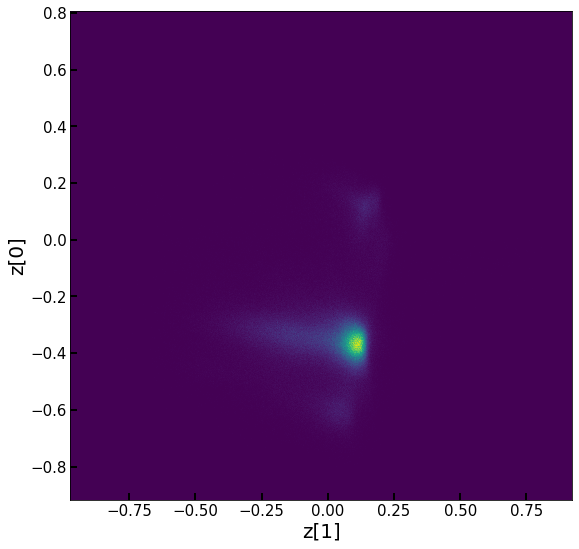

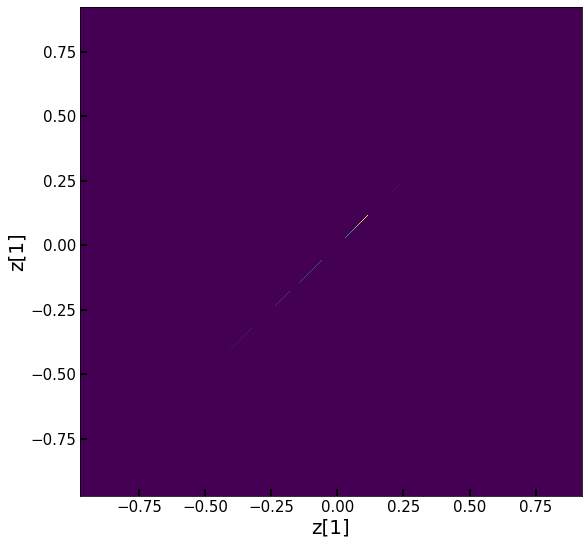

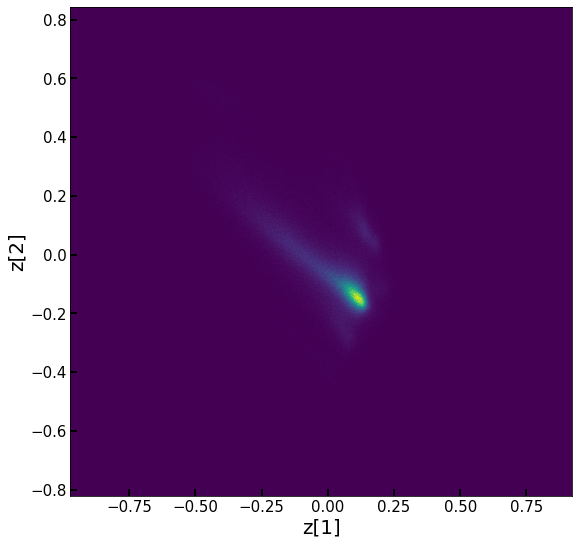

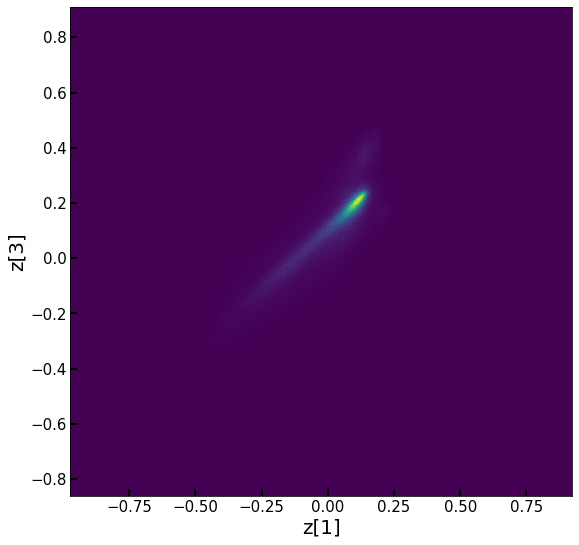

In [23]:
for i in range(4):
    plt.figure(figsize=(9,9))
    plt.hist2d(z[:,1],z[:,i],bins=1000,density=True)
    plt.xlabel('z[1]',size=20)
    plt.ylabel('z[%i]'%i,size=20)
    plt.tick_params(axis='both',labelsize=15, direction = 'in',width=2,length=7,which='major')
    plt.show()

There are sharp cuts (like z[0] vs z[1]) and also discontinued pattern (like z[2] vs z[1])

=> This may suggest that there are cases like 0->2$\pi$